# What is my task?

Mr Cj needs a model to predict users comments are positive or negative, i decided to use *imbd* dataset and i want to fine-tune BERT model for this task.

# What do i have?

Dataset Summary:

Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

Our dataset is some thing like:
```json
{
    "label": 0,
    "text": "Goodbye world2\n"
}
```

But now let me make dataset ready for next parts:

In [1]:
import datasets
data = datasets.load_dataset("stanfordnlp/imdb")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [2]:
data.save_to_disk("./dataset")

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
data = datasets.load_from_disk("./dataset")

# Hands on Code!!

## Import needed libraries

In [ ]:
try:
    import datasets, evaluate, accelerate, transformers
    import gradio
    from sklearn.metrics import classification_report, ConfusionMatrixDisplay
except:
    ! pip install datasets evaluate accelerate gradio transformers
    import datasets, evaluate, accelerate
    import gradio

import torch
import numpy as np
import transformers
import random
from pathlib import Path

TRAIN_EPOCHS = 3
BATCH_SIZE = 32
RANDOM_SEED = 42
DOWNLOAD_MODEL_NAME = 'distilbert/distilbert-base-uncased'
MY_MODEL_NAME = "imdb-text-classifier"

## Load and understand dataset

In [5]:
try:
    data = datasets.load_from_disk("./dataset")
except(FileNotFoundError):
    data = datasets.load_dataset("stanfordnlp/imdb")
    data.save_to_disk("./dataset")


In [6]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

I think i'll not use this dataset's `unsupervised` data.
One more think, im afraid of gpu limit's in here, so i may not use all of data in dataset.

In [7]:
from datasets import DatasetDict

reduction_rate    = 1
num_train_to_keep = int(reduction_rate * data["train"].num_rows)
num_test_to_keep  = int(reduction_rate * data["test"].num_rows)

random.seed(RANDOM_SEED)
def select_dataset_indices(dataset, keep):
    indices = list(range(dataset.num_rows))
    random.shuffle(indices)
    return indices[:keep]

train_indices = select_dataset_indices(dataset=data['train'], keep=num_train_to_keep)
test_indices = select_dataset_indices(dataset=data['test'], keep=num_test_to_keep)

data_imdb = DatasetDict({
    'train': data['train'].select(train_indices),
    'test':data['test'].select(test_indices)
})

data_imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [8]:
data_imdb['train'][45]['text'], data_imdb['train'][45]['label']

('This movie changed it all for me...I heard of breakdancing and hiphop, but had never seen it professionally done (hey I was an 11-year old kid from Holland!) When I saw this movie, this all changed. I got actively involved in the hiphop-movement in our city, started breakdancing and writing lyrics.<br /><br />To this day, I still consider this movie to be a personal favorite. Sure, the filming and "cinematographic" importance might not be that significant. But who cares if the wide-shot was filmed badly or if you could see a mic hanging above somebody? It\'s what it does to you personally that counts...',
 1)

# Preprocess data

I want to:
1. Lower case sentences.
2. Tokenize texts (turn sentence into words and words into number)

**Note**: in old *bag of words* models we removed stopwords and we did Lemmatization, But in *DistilBERT* we don't need to! because it dose not count words.

### Lower case sentences

In [9]:
def lower_case(example):
    return {"text": [text.lower() for text in example['text']]}

In [10]:
print(data_imdb['train'][0])
# data_imdb = data_imdb.map(lower_case, batched=True, batch_size=BATCH_SIZE)
print(data_imdb['train'][0])

{'text': 'Eric Clapton, Jack Bruce and Ginger Baker re-unite to play all their songs from 35 years ago when they formed a trio called "Cream." Those were the psychedelic days of England and America and these guys looked it: all skinny, very long hair, wild clothes and loud music. They played a combination of rock and blues and it was, for the most part, good stuff.<br /><br />Well, these guys are now 60-something years old and they can still sing and play at a high level as this wonderful DVD concert disc shows us. I was always extremely familiar with Clapton, of course, who has never been out of the limelight, but I didn\'t know what to expect from Bruce and Baker, neither of whom I hadn\'t seen in decades. They surprised me. When he was young, Baker was so gaunt he looked like a speed freak near death. Now he looks healthy, in shape and his drum playing was solid. Bruce looked a bit haggard but his voice is great, as good as ever and a pleasure to hear on these old songs. This is jus

In [11]:
data_imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

### Tokenize texts

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=DOWNLOAD_MODEL_NAME, use_fast=True)
tokenizer

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

BertTokenizer(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [13]:
tokenizer("hello world!!")

{'input_ids': [101, 7592, 2088, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

It is working fine in tokenizing, it turned `hello world!!` into `[101, 7592, 2088, 999, 999, 102]`.

But what is the maximum sequence length that this tokenizer can tokenize? It is **512**

And how many vocabs this tokenizer has? It has **30522**

In [14]:
print(f"Maximum tokenizer sequence: {tokenizer.model_max_length}")
print(f"numebr of vocabs in tokenizer: {len(tokenizer.vocab)}")

Maximum tokenizer sequence: 512
numebr of vocabs in tokenizer: 30522


In [15]:
def tokenize_text(example):
    return tokenizer(
        example['text'],
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length # Ensure consistent length for all inputs
    )

In [16]:
data_imdb = data_imdb.map(tokenize_text, batched=True, batch_size=BATCH_SIZE, load_from_cache_file=False)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

It works well, now let's download model for clasification.

## Model

### Download and config model

We need to define our labels for downloaded model

In [17]:
label2id = {'negative':0, 'positive':1}
id2label = {0:'negative', 1:'positive'}

In [18]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=DOWNLOAD_MODEL_NAME,
    num_labels=2,
    label2id=label2id,
    id2label=id2label
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert/distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [19]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


This model has the following parts:
1. **embeddings**: it is a form of learned representation of tokens.
2. **transformer**: this is models architecture backbone, it'll fine patterns in embeddings.
3. **classifier**: this part will get customized for our task.

Now, how many parameters are trainable in this model? or even how many parameters this model has?

In [20]:
def count_params(model):
    trainables = sum(param.numel() for param in model.parameters() if param.requires_grad)
    all = sum(param.numel() for param in model.parameters())
    print(f"there are {trainables} trainable and total parameters are {all}.")
    print(f"{trainables/all * 100}% are trainable.")

In [21]:
count_params(model)

there are 66955010 trainable and total parameters are 66955010.
100.0% are trainable.


### Setup model path

In [22]:
model_dir = Path("models")
model_dir.mkdir(exist_ok=True)

model_name_to_save = Path(model_dir / MY_MODEL_NAME)
model_name_to_save

PosixPath('models/imdb-text-classifier')

### Setup evaluation metrics

In [23]:
accuracy_metrics = evaluate.load("accuracy")
# precision_metrics = evaluate.load("precision")
# recall_metrics = evaluate.load("recall")
# f1_metrics = evaluate.load("f1")

def compute_metrics(preds_labels):
  preds, labels = preds_labels
  predictions = np.argmax(preds, axis=1)

  # accuracy = accuracy_metrics.compute(predictions=predictions, references=labels)
  # precision = precision_metrics.compute(predictions=predictions, references=labels, zero_division=0)
  # recall = recall_metrics.compute(predictions=predictions, references=labels, zero_division=0)
  # f1 = f1_metrics.compute(predictions=predictions, references=labels)

  # return DatasetDict({
  #     "Accuracy": accuracy,
  #     "Precision": precision,
  #     "Recall": recall,
  #     "F1": f1,
  # })

  return accuracy_metrics.compute(predictions=predictions, references=labels)

### Define trainig arguments

In [29]:
from transformers import TrainingArguments

trainArgs = TrainingArguments(
    output_dir=model_name_to_save,
    learning_rate=2e-5,
    per_device_eval_batch_size=BATCH_SIZE,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=TRAIN_EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cache=False,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    seed=RANDOM_SEED,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    push_to_hub=True,
    hub_model_id='sirunchained/imdb-text-classifier'
)

In [30]:
trainArgs

TrainingArguments(
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
enable_jit_checkpoint=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=Fals

### Define trainer

In [31]:
from transformers import Trainer, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=trainArgs,
    train_dataset=data_imdb['train'],
    eval_dataset=data_imdb['test'],
    # data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.117282,0.267643,0.913680
2,0.096861,0.281057,0.924760
3,0.052957,0.297531,0.930000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=2346, training_loss=0.08903330406975969, metrics={'train_runtime': 4789.3023, 'train_samples_per_second': 15.66, 'train_steps_per_second': 0.49, 'total_flos': 9935054899200000.0, 'train_loss': 0.08903330406975969, 'epoch': 3.0})

Wait! I can smell overfit here!

In [33]:
trainer_hist = trainer.state.log_history
trainer_hist_metrics = trainer_hist[:-1]

trainer_hist_metrics

[{'loss': 0.11728227229984216,
  'grad_norm': 4.384761810302734,
  'learning_rate': 1.3341858482523444e-05,
  'epoch': 1.0,
  'step': 782},
 {'eval_loss': 0.267642617225647,
  'eval_accuracy': 0.91368,
  'eval_runtime': 397.0648,
  'eval_samples_per_second': 62.962,
  'eval_steps_per_second': 1.969,
  'epoch': 1.0,
  'step': 782},
 {'loss': 0.09686091001076466,
  'grad_norm': 22.37566566467285,
  'learning_rate': 6.675191815856779e-06,
  'epoch': 2.0,
  'step': 1564},
 {'eval_loss': 0.2810574173927307,
  'eval_accuracy': 0.92476,
  'eval_runtime': 399.136,
  'eval_samples_per_second': 62.635,
  'eval_steps_per_second': 1.959,
  'epoch': 2.0,
  'step': 1564},
 {'loss': 0.052956729898672276,
  'grad_norm': 2.4069268703460693,
  'learning_rate': 8.525149190110827e-09,
  'epoch': 3.0,
  'step': 2346},
 {'eval_loss': 0.29753080010414124,
  'eval_accuracy': 0.93,
  'eval_runtime': 399.1176,
  'eval_samples_per_second': 62.638,
  'eval_steps_per_second': 1.959,
  'epoch': 3.0,
  'step': 2346}

## Save model to HF

In [34]:
trainer.push_to_hub(
    commit_message="making model backup in hugging face"
)

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ssifier/training_args.bin: 100%|##########| 5.20kB / 5.20kB            

  ...ssifier/model.safetensors:  13%|#2        | 33.5MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/sirunchained/imdb-text-classifier/commit/b21096de85b98c02357416883e445e3e8e742f01', commit_message='making model backup in hugging face', commit_description='', oid='b21096de85b98c02357416883e445e3e8e742f01', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sirunchained/imdb-text-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='sirunchained/imdb-text-classifier'), pr_revision=None, pr_num=None)

## Evaluate

In [36]:
preds = trainer.predict(data_imdb['test'])
pred_values = preds.predictions
preds

PredictionOutput(predictions=array([[-3.4794347 ,  3.0211651 ],
       [-3.4345076 ,  3.0140042 ],
       [ 3.4998796 , -3.2623615 ],
       ...,
       [ 3.4696105 , -3.2118187 ],
       [-0.6473748 ,  0.39459676],
       [-3.1504445 ,  2.7111511 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 0, 1]), metrics={'test_loss': 0.29753080010414124, 'test_accuracy': 0.93, 'test_runtime': 399.8951, 'test_samples_per_second': 62.516, 'test_steps_per_second': 1.956})

This is logits, we need to get probebility by apply a softmax function:

In [37]:
preds_prob = torch.softmax(torch.tensor(pred_values), dim=1)

preds_label = torch.argmax(preds_prob, dim=1)

preds_label

tensor([1, 1, 0,  ..., 0, 1, 1])

In [45]:
print(classification_report(data_imdb['test']['label'], preds_label))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     12500
           1       0.93      0.93      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



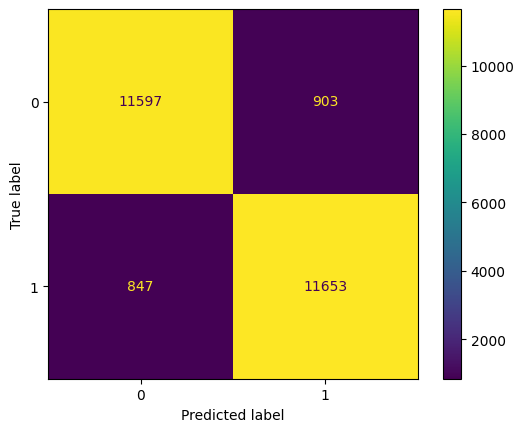

In [46]:
ConfusionMatrixDisplay.from_predictions(data_imdb['test']['label'], preds_label)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=tokenizer.model_max_length)
    inputs = {k: v.to(device) for k, v in inputs.items()} # Move inputs to the correct device
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_label_id = torch.argmax(probabilities, dim=1).item()
    return id2label[predicted_label_id]

iface = gradio.Interface(fn=predict_sentiment, inputs="text", outputs="text", title="IMDb Sentiment Analysis")

iface.launch(debug=True, share=False)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>